## Optimization of Attainable Control Set for tiltrotor by tilt angles
*Copyright (C) 2024  Uwe Klingauf, Tilman Strampe*

<font size="1"> *This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version. This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details. You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.* </font>

This example shows the optimization of the control radius in the roll-pitch plane of the ACS for a tiltrotor. By changing the tilt angles $\lambda$ the set is optimized. 
Additionally, the weights of a weighted pseudo-inverse are optimized by the tilt angles.

In [1]:
import numpy as np
import pypoman as pm
import math 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
import tiltrotor_eff_matrix as motor_matrix
from plotACS import plotACS

In [2]:
# define parameters
n_fault = 4        # faulty rotor (1...8)
T_max = 2.0        # maximum rotor thrust in [kgf]
mass = 5           # total mass in [kg]
g = 9.80665        # gravitational acceleration [m/s^2]
dxy = 0.32         # Position of rotors relative to cg in x- and y-direction
s = 1.827          # Wing span (assuming rotors and wing tips)
ct = 1.0           # rotor thrust constant
cm = 0.0192        # rotor torque constant
tilt = [0.0, 0.0]  # tilt angles of outer rotors 


# compute nominal actuator effectiveness matrix B_nom
param = motor_matrix.parameters(tilt, ct, cm, dxy, s)
B_nom = motor_matrix.motor_matrix(param)
B_nom[0:3,:] = B_nom[0:3,:]*g  # moments in [Nm], thrust in [kgf]
B_nom[5,:] = -B_nom[5,:]  # thrust vector pointing up
B_nom = np.delete(B_nom, [3, 4], 0)  # acceleration X and side force Y are neglected
print(B_nom.round(4))

# compute actuator effectiveness matrix for faulty rotor n_fault
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
# print(B_fault)

# compute control allocation matrix via pseudo-inverse
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
#print(B_f_plus)

[[-3.1381  3.1381  8.9584  3.1381 -3.1381 -8.9584]
 [ 3.1381  3.1381  0.     -3.1381 -3.1381  0.    ]
 [-0.1883  0.1883  0.1883 -0.1883  0.1883 -0.1883]
 [ 1.      1.      1.      1.      1.      1.    ]]


In [3]:
# set inequality constraints for attainable control set (ACS)
A = np.kron(np.eye(6),np.array([[1.0],[-1.0]]))
b = np.array([T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0, T_max, 0.0])
ineq = (A, b)
b_fault = np.copy(b)
b_fault[2*(n_fault-1)] = 0.0  # set faulty rotor thrust to zero
ineq_fault = (A, b_fault)     # inequality constraints for polytope A * x <= b
ineq_f_pseudo = (A @ B_f_plus, b_fault)

In [4]:
# weighting matrix for roll, pitch, yaw moments
wr = 1.0
wp = 1.0
wy = 0.1
E_inv = np.diag(np.array([wr*wr, wp*wp, wy*wy]))  # ellipsoid x^T E x = e

In [5]:
# compute minimum radius of roll / pitch control polytope
def ellipsoid(tilt):
    param = motor_matrix.parameters(tilt, ct, cm, dxy, s)
    B = motor_matrix.motor_matrix(param)
    B[0:3,:] = B[0:3,:]*g  # moments in [Nm], thrust in [kgf]
    B[5,:] = -B[5,:]  # thrust vector pointing up
    B = np.delete(B, [3, 4], 0)
    proj = (B[[0, 1, 2],:], np.zeros(3))  # 2D projection of polytope y = E * x + f, select roll and pitch and yaw axis
    eq = (B[[3],:], np.array([mass]))  # equality constraints C * x = d, thrust = mg
    vertices_fault = np.array(pm.project_polytope(proj, ineq_fault, eq, method='ccn'))  # determine closest distance of roll/pitch polytope to origin
    A_res, b_res = pm.compute_polytope_halfspaces(vertices_fault) # compute half space representation from vertices

    # compute ellipsoid
    e = np.zeros(len(b_res))
    for i in range(len(b_res)):  
        e[i] = b_res[i] * b_res[i] / (A_res[i,:] @ E_inv @ np.transpose(A_res[i,:]))
    e_min = min(e)        # find minimum e
    e_min = max(0,e_min)  # constrain e to e>=0

    return -e_min         # multiply objective function by -1 to change max problem to min problem
    

### Calculation of ACS for tilt angles $\lambda_1=0,\, \lambda_2=0$
The following plots show the ACS for tilt angles $\lambda_1=0,\, \lambda_2=0$ in two dimensions. In blue the ACS of an tiltrotor without any failure is shown, in red the ACS for a failure of rotor 1. The yellow area is the achievable ACS using a pseudo-inverse for Control Allocation. The ellipsoid's radius in the roll-pitch plane is shown in black.

For tilt angles lambda_1 = 0.00° and lambda_2 = 0.00° the sqrt of ellipsoid scale factor e is  0.00 Nm


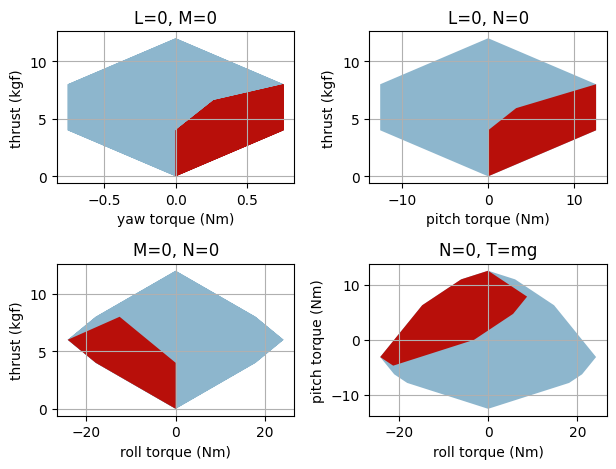

In [6]:
e = -ellipsoid(tilt)
print("For tilt angles lambda_1 = %3.2f° and lambda_2 = %3.2f° the sqrt of ellipsoid scale factor e is %5.2f Nm" % (tilt[0]*90, tilt[1]*90, np.sqrt(e)))
fig_mu0 = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, np.sqrt(e), 0)
fig_mu0.savefig("acs_mu0.png") # save as png

### Optimization of ACS using tilt angles
Next, the radius in the roll-pitch plane is optimized by using the tilt angles. 

For tilt angles lambda_1 = -1.00° and lambda_2 = 1.37° the sqrt of ellipsoid scale factor e is  4.05 Nm


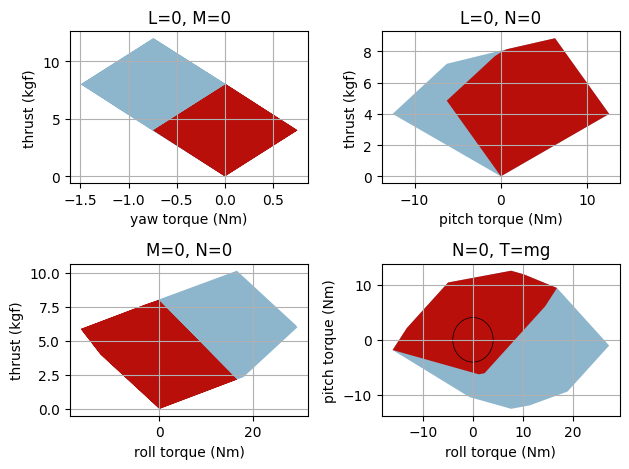

In [11]:
# Optimize the inclination mu
x0 = [0, 0.01]
bnds = ((-0.1, 1), (-0.1, 1))  # 100% tilt corresponds to 90 deg
res = minimize(ellipsoid, x0, method='Nelder-Mead', bounds=bnds, tol=1e-6)
tilt_opt = res.x

e_opt = -ellipsoid(tilt_opt)
print("For tilt angles lambda_1 = %3.2f° and lambda_2 = %3.2f° the sqrt of ellipsoid scale factor e is %5.2f Nm" % (tilt_opt[0]*90, tilt_opt[1]*90, np.sqrt(e_opt)))
B_nom = motor_matrix.motor_matrix(motor_matrix.parameters(tilt_opt, ct, cm, dxy, s))
B_nom[0:3,:] = B_nom[0:3,:]*g        # moments in [Nm], thrust in [kgf]
B_nom[5,:] = -B_nom[5,:]             # thrust vector pointing up
B_nom = np.delete(B_nom, [3, 4], 0)  # acceleration X and side force Y are neglected
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
ineq_f_pseudo = (A @ B_f_plus, b_fault)
fig_opt = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, np.sqrt(e_opt), 0)

### Optimization of weighted pseudo-inverse for Control allocation
The radius in the roll-pitch plane is now used to optimize the weights of a weighted pseudo-inverse. For the input matrix $B$ with
$$
\nu = B\cdot u
$$
the weighted pseudo-inverse is given by

$$ B^{+}=W^{-1}B^{T}(B W^{-1} B^{T})^{-1} $$

where $W$  diagonal weight matrix.rix.

In [8]:
def ellipsoid_w(w):
    # compute weighted pseudo-inverse
    we = np.insert(w, n_fault-1, 1)  # insert weight for faulty rotor set to 1
    W = np.diag(we)                  # weighting matrix
    WI = np.linalg.inv(W)            # inverse weighting matrix
    B_f_plus = WI @ np.transpose(B_fault) @ np.linalg.inv((B_fault @ WI @ np.transpose(B_fault)))
    
    # 2D projection of polytope y = E * x + f, select roll and pitch axis
    proj = (np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]), np.zeros(3))
    ineq_f_pseudo = (A @ B_f_plus, b_fault)                      # inequality constraints for polytope A * x <= b
    eq = (np.array([[0,0,0,1]]), np.array([mass]))  # equality constraint for yaw = 0 and thrust = mass
    vertices_f_pseudo = np.array(pm.project_polytope(proj, ineq_f_pseudo, eq, method='ccn'))
    
    # compute half space representation from vertices
    A_res, b_res = pm.compute_polytope_halfspaces(vertices_f_pseudo)

    # compute ellipsoid
    e = np.zeros(len(b_res))
    for i in range(len(b_res)):  
        e[i] = b_res[i] * b_res[i] / (A_res[i,:] @ E_inv @ np.transpose(A_res[i,:]))
    e_min = min(e)  # find minimum e
    e_min = max(0,e_min)  # constrain e to e>=0
    return -e_min  # multiply objective function by -1 to change max problem to min problem


Optimum weighting factors:  [1.75 0.5  0.13 1.   1.06 0.58]
The sqrt of ellipsoid scale factor e with CA is 4.01 Nm


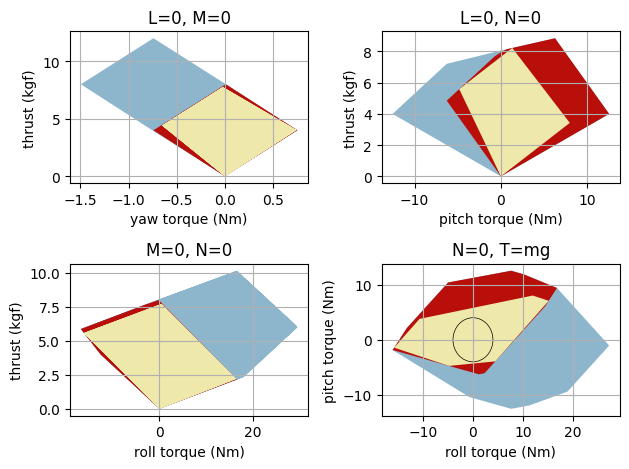

In [12]:
# find optimum weighting matrix for weighted pseudo-inverse
w0 = np.ones(5)
bnds = ((0.1, 2),)*5  # set lower and upper bound for weights
res = minimize(ellipsoid_w, w0, method='Nelder-Mead', bounds=bnds, tol=1e-6)
e_opt = -ellipsoid_w(res.x)
with np.printoptions(precision=2, suppress=True):
    print("Optimum weighting factors: ", np.insert(res.x, n_fault-1, 1))
print("The sqrt of ellipsoid scale factor e with CA is %4.2f Nm" % (math.sqrt(e_opt)))

# compute resulting weighted pseudo-inverse
we = np.insert(res.x, n_fault-1, 1)  # insert weight for faulty rotor set to 1
W = np.diag(we)  # weighting matrix
WI = np.linalg.inv(W)  # inverse weighting matrix
B_f_plus = WI @ np.transpose(B_fault) @ np.linalg.inv((B_fault @ WI @ np.transpose(B_fault)))  # calculate pseudo-inverse
ineq_f_pseudo = (A @ B_f_plus, b_fault)
fig_opt = plotACS(B_nom, ineq, ineq_fault, ineq_f_pseudo, mass, math.sqrt(e_opt), 1)
fig_opt.savefig("acs_tiltcopter_ellipsoid_weightOpt.eps") # save figure

### Calculation of rotor loads for hovering
Using the weighted pseudo-inverse, the rotor loads are calculated for the hovering condition, i.e. all torques are zero and total thrust is equal to the copter's weight. 

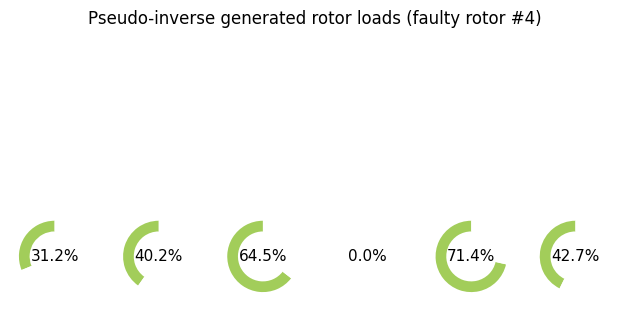

In [10]:
# calculate the rotor loads in hovering state
v_cmd = np.array([0,0,0,mass])  # steady state L, M, N equal zero, thrust = weight
B_fault = np.copy(B_nom)
B_fault[:,n_fault-1] = 0.0
B_f_plus = np.transpose(B_fault) @ np.linalg.inv((B_fault @ np.transpose(B_fault)))  # calculate pseudo-inverse
u = B_f_plus @ np.transpose(v_cmd)
v = B_fault @ u
# print(u)
# print(v)

fig, ax = plt.subplots(1,6)
fig.suptitle("Pseudo-inverse generated rotor loads (faulty rotor #{0:d})".format(n_fault))

# plot donut charts
for i in range(6):
    value = u[i]/T_max
    if(value<0.0):
        value = 0.0
    if value > 0.9:
        colors = ['#EE2C2C', '#FFFFFF']
    elif value > 0.8:
        colors = ['#EEC900', '#FFFFFF']
    else:
        colors = ['#A2CD5A', '#FFFFFF']
    if value > 1:
        ax[i].pie([1,0], wedgeprops={'width':0.3}, startangle=90, colors=colors)
    else:
        ax[i].pie([value,1-value], wedgeprops={'width':0.3}, startangle=90, colors=colors)
    ax[i].text(0, 0, "{0:.1f}%".format(value*100), ha='center', va='center', fontsize=11)

fig.tight_layout()
plt.show()
fig.savefig("loads.png")